In [163]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import datetime 
import time
from scipy.stats import binned_statistic_2d

**Загрузка данных за май 2016 года**

In [164]:
df = pd.read_csv('./TAXI DATA/2016/yellow_tripdata_2016-05.csv')

In [165]:
raw_data = df.iloc[:, 1:7]
raw_data.columns = ['pickup_datetime', 'dropoff_datetime', 'passenger_count', 
                    'trip_distance', 'pickup_longitude', 'pickup_latitude']

In [166]:
raw_data.head(5)

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude
0,2016-05-01 00:00:00,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040
1,2016-05-01 00:00:00,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751
2,2016-05-01 00:00:00,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573
3,2016-05-01 00:00:00,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601
4,2016-05-01 00:00:00,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192


In [167]:
print 'Размер исходного датасета:',raw_data.shape

Размер исходного датасета: (11836853, 6)


In [168]:
print 'Размер датасета после фильтрации по строкам с Nan значениями:',raw_data.dropna().shape

Размер датасета после фильтрации по строкам с Nan значениями: (11836853, 6)


Пропущенных значений нет

**Фильтрация данных**

Критерии фильтрации: 

* нулевая длительность поездок
* нулевое количество пассажиров
* нулевое расстояние поездки по счётчику
* координаты начала поездки, не попадающими в прямоугольник Нью-Йорка (от -74.25559 до -73.70001 градусов долготы и от 40.49612 до 40.91553 широты)

In [169]:
filter1 = raw_data['dropoff_datetime'] > raw_data['pickup_datetime']
filter2 = raw_data['passenger_count'] > 0
filter3 = raw_data['trip_distance'] > 0
filter4 = (raw_data['pickup_longitude'] >= -74.25559) & (raw_data['pickup_longitude'] <= -73.70001)
filter5 = (raw_data['pickup_latitude'] >= 40.49612) & (raw_data['pickup_latitude'] <= 40.91553)

In [170]:
data = raw_data[filter1 & filter2 & filter3 & filter4 & filter5]

In [171]:
print 'Размер датасета после фильтрации:',data.shape

Размер датасета после фильтрации: (11626521, 6)


In [172]:
data.describe()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude
count,1.162652e+07,1.162652e+07,1.162652e+07,1.162652e+07
mean,1.665547e+00,6.183120e+00,-7.397297e+01,4.075091e+01
std,1.307689e+00,5.201581e+03,3.891102e-02,2.853368e-02
min,1.000000e+00,1.000000e-02,-7.425517e+01,4.051407e+01
25%,1.000000e+00,1.020000e+00,-7.399193e+01,4.073718e+01
50%,1.000000e+00,1.750000e+00,-7.398161e+01,4.075435e+01
75%,2.000000e+00,3.300000e+00,-7.396674e+01,4.076882e+01
max,9.000000e+00,1.200000e+07,-7.370009e+01,4.091525e+01


In [173]:
data.head()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude
0,2016-05-01 00:00:00,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040
1,2016-05-01 00:00:00,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751
2,2016-05-01 00:00:00,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573
3,2016-05-01 00:00:00,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601
4,2016-05-01 00:00:00,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192


**Подготовка данных**

Конверитруем значения pickup_datetime и dropoff_datetime в time data. Отбросим минуты и секунды от времени начала поездки.

In [174]:
data.loc[:, 'dropoff_datetime'] = pd.to_datetime(data.loc[:, 'dropoff_datetime'])
data.loc[:, 'pickup_datetime'] = pd.to_datetime(data.loc[:, 'pickup_datetime']).dt.floor('h')

In [175]:
data.head()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude
0,2016-05-01,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040
1,2016-05-01,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751
2,2016-05-01,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573
3,2016-05-01,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601
4,2016-05-01,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192


**Агрегирование данных по часам и областям**

Подготовка координат

In [176]:
min_long = -74.25559
max_long = -73.70001
min_lat = 40.49612
max_lat = 40.91553

In [177]:
def set_long_id(item):
    '''
    Принимает значение(я) долготы. Возвращает id в диапазоне от 0 до 50
    '''
    return np.floor((item - min_long)*50/(max_long - min_long))

def set_lat_id(item):
    '''
    Принимает значение(я) широты. Возвращает id в диапазоне от 0 до 50
    '''
    return np.floor((item - min_lat)*50/(max_lat - min_lat))

def generate_zone_id(longitude, latitude):
    '''
    Принимает координаты точки(точек). Возвращает id места в диапазоне от 0 до 2500
    '''
    return int(set_long_id(longitude)*50 + set_lat_id(latitude))


In [178]:
data.loc[:,'long_id'] = data.loc[:, 'pickup_longitude'].apply(lambda x: set_long_id(x))
data.loc[:,'lat_id'] = data.loc[:, 'pickup_latitude'].apply(lambda x: set_lat_id(x))
data.loc[:,'zone_id'] = (data.loc[:,'long_id'])*50 + data.loc[:,'lat_id']
                                                       

In [179]:
data.head()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,long_id,lat_id,zone_id
0,2016-05-01,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,24.0,32.0,1232.0
1,2016-05-01,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,23.0,29.0,1179.0
2,2016-05-01,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,23.0,29.0,1179.0
3,2016-05-01,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,23.0,22.0,1172.0
4,2016-05-01,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,22.0,29.0,1129.0


Подготовим значения начала поездки, пригодные для агрегирования. Закодируем даты в int.

In [187]:
def set_date_like_int(date):
    '''
    Принимает стобец датафрейма в формате timedate
    Возвращает время начала поездки в формате yyyymmddhh
    '''
    return date.dt.year*1e6 + date.dt.month*1e4 + date.dt.day*1e2 + date.dt.hour

In [241]:
def time_bin_gen(date):
    current_month = np.unique(np.array(date.dt.year*1e6 + date.dt.month*1e4 + date.dt.day*1e2 + date.dt.hour))
    add_date = [date.dt.year[0]*1e6 + (date.dt.month[0]+1)*1e4]    
    return np.concatenate((current_month, add_date))

In [201]:
data.loc[:, 'start_time'] = set_date_like_int(data['pickup_datetime'])

In [202]:
data.head()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,long_id,lat_id,zone_id,start_time
0,2016-05-01,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,24.0,32.0,1232.0,2.016050e+09
1,2016-05-01,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,23.0,29.0,1179.0,2.016050e+09
2,2016-05-01,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,23.0,29.0,1179.0,2.016050e+09
3,2016-05-01,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,23.0,22.0,1172.0,2.016050e+09
4,2016-05-01,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,22.0,29.0,1129.0,2.016050e+09


Агрегирование:

In [288]:
time_bin = time_bin_gen(data['pickup_datetime'])
id_bin = np.arange(0, 2501)

In [289]:
res = binned_statistic_2d(data['zone_id'], data['start_time'],  None, 'count', bins = [id_bin, time_bin])
 

In [290]:
agr = res.statistic
agr

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [291]:
agr.shape

(2500L, 744L)

Визуализируем распределение поездок

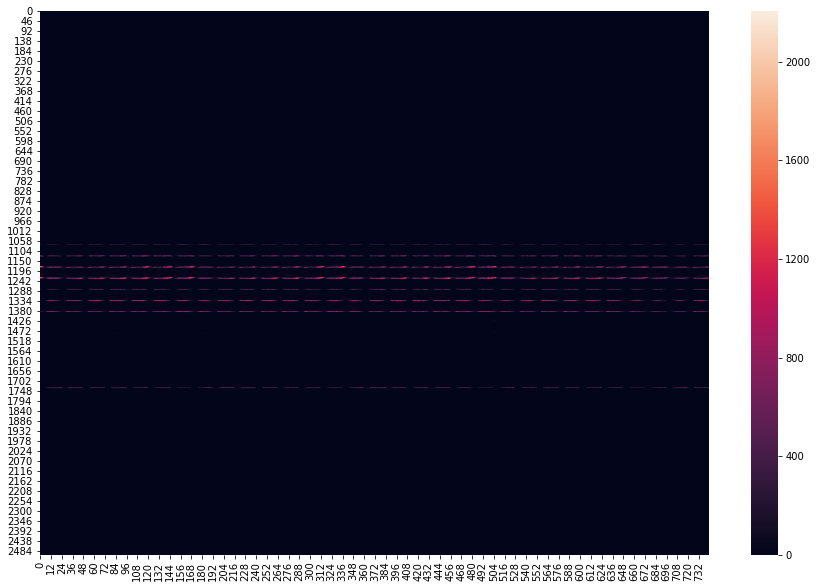

In [292]:
plt.figure(figsize = (15, 10))
sns.heatmap(agr)

Создадим таблицу результатов агрегирования

In [293]:
df_agr_values = pd.DataFrame()
df_agr_values['date and time'] = data.pickup_datetime.unique()

#вспомогательный df
df_agr_numbers = pd.DataFrame(agr.T, columns = np.arange(1, 2501))

df_agr_values = pd.concat([df_agr_values, df_agr_numbers], axis = 1)

In [294]:
df_agr_values.head()

,date and time,1,2,3,4,5,6,7,8,9,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
0,2016-05-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2016-05-04 22:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2016-05-04 23:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2016-05-05 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2016-05-05 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [295]:
df_agr_values.tail()

,date and time,1,2,3,4,5,6,7,8,9,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
739,2016-05-31 19:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
740,2016-05-31 20:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
741,2016-05-31 21:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
742,2016-05-31 22:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
743,2016-05-31 23:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Найдем координаты Empire State Building и id ячейки с ним 

In [300]:
empire_lat = 40.748306  
empire_long = -73.985756
empire_id = generate_zone_id(empire_long, empire_lat)+1
print empire_id

1231


Распределние поездок в течении суток в районе Empire State Building (id 1231)

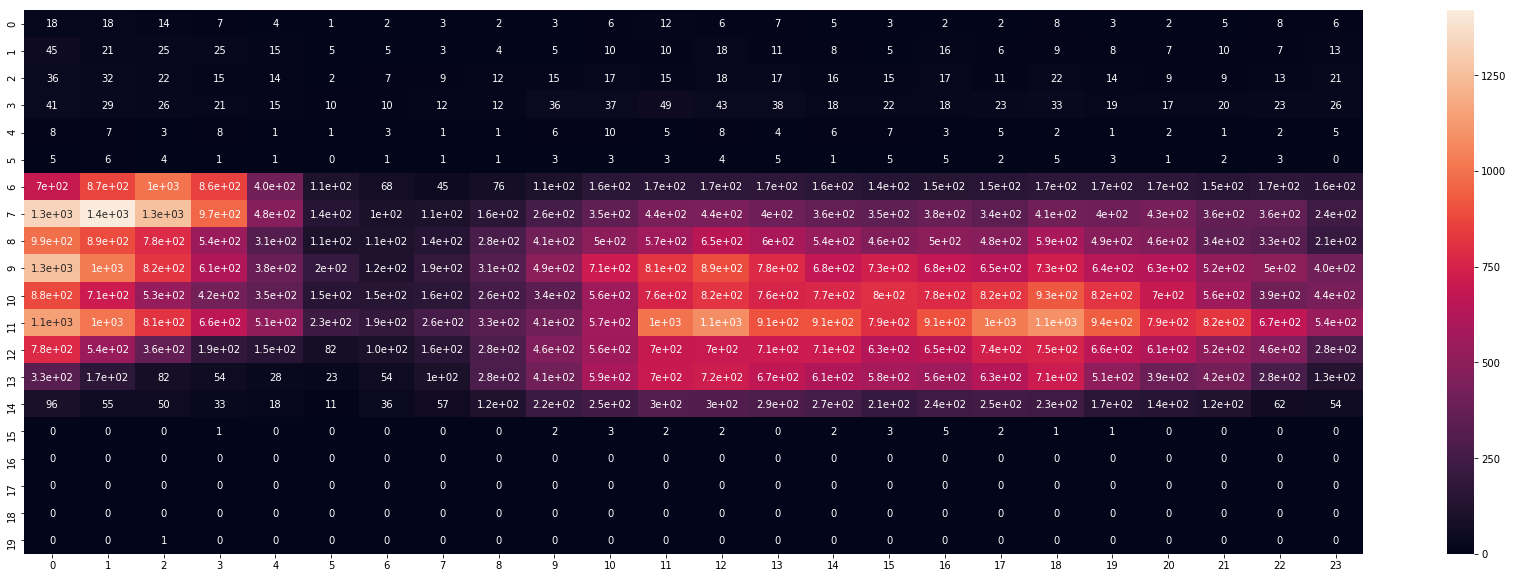

In [301]:
plt.figure(figsize = (30, 10))
sns.heatmap(agr[1220:1240, :24], annot = True)

Распредение поездок из сектора с Empire State Building за май 2016

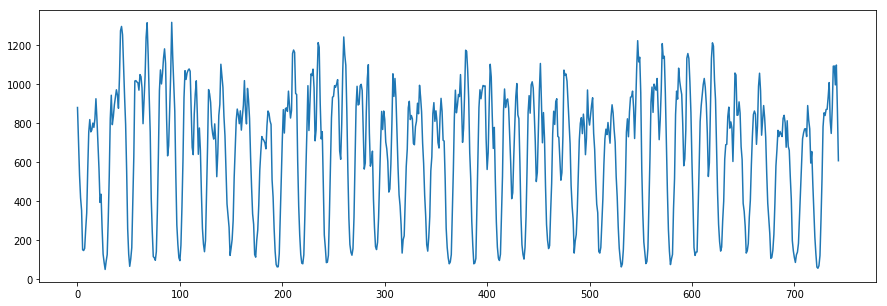

In [303]:
plt.figure(figsize = (15, 5))
df_agr_values.iloc[: , empire_id].plot()

Количетво ячеек с нулевым значениями:

In [304]:
np.size(agr) - np.count_nonzero(agr)

1718238

Сохраним датафрейм в отдельный файл

In [305]:
df_agr_values.to_pickle("TAXI DATA/PICKLES/2016_05.pkl")